### Movie Lens Recommendation System

In [1]:
import numpy as np
import pandas as pd

##### Data Processing

In [2]:
movie=pd.read_csv("movies.csv",index_col="movieId")

In [3]:
movie.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings=pd.read_csv("ratings.csv")

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
data=pd.merge(movie,ratings,left_index=True, right_on="movieId")

In [7]:
data.head()

,title,genres,userId,movieId,rating,timestamp
495,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,1,3.0,851866703
699,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,1,4.0,938629179
889,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,1,5.0,1331380058
962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,1,2.0,997938310
3105,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,1,3.0,855190091


#### Create movie-rating matrix

In [8]:
movie_user=data.pivot_table(index=["userId"],columns=["movieId"],values="rating")

In [9]:
movie_user.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
movie_user.shape

(671, 9066)

In [11]:
sparsity=movie_user.notnull().sum().sum()/(movie_user.shape[0]*movie_user.shape[1])
sparsity*=100
sparsity

1.6439141608663475

In [12]:
##Since non-null values are in such small portion, so we need to fill all null values with 0
umfilled=movie_user.fillna(0).as_matrix()

F:\aneconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### Split Trainning, Testing dataset

In [13]:
def train_val_split(ratings):
    val=np.zeros(ratings.shape)
    train=ratings.copy()
    for user in range(ratings.shape[0]):
        val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=int(len(ratings[user, :].nonzero()[0])*0.2), 
                                        replace=False)
        train[user, val_ratings] = 0.
        val[user, val_ratings] = ratings[user, val_ratings]
        
    # val and training are truly disjoint
    assert(np.all((train * val) == 0)) 
    return train, val

In [14]:
train,val=train_val_split(umfilled)

In [15]:
train.shape

(671, 9066)

In [16]:
val.shape

(671, 9066)

### Recommendation System Creating Based on Cosine Similarity

In [17]:
## Generate cosine similarity matrix
def cos_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'movie':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [18]:
user_similarity=cos_similarity(train,kind="user")
movie_similarity=cos_similarity(train, kind='movie')

In [20]:
##Define predict functions
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'movie':
        movie_bias = ratings.mean(axis=0)
        ratings = (ratings - movie_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += movie_bias[np.newaxis, :]
        
    return pred

In [21]:
user_prediction=predict(train,user_similarity,kind="user")
movie_prediction=predict(train,movie_similarity,kind="movie")

In [22]:
##Calculate time for this functions
%timeit user_prediction=predict(train,user_similarity,kind="user")

1.17 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit movie_prediction=predict(train,user_similarity,kind="user")

1.08 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
##Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [26]:
##Print RMSE
print ('User-based bias-adjusted CF RMSE: %.2f' %rmse(user_prediction, val))
print ('Movie-based bias-adjusted CF RMSE: %.2f' %rmse(movie_prediction, val))

User-based bias-adjusted CF RMSE: 3.20
Movie-based bias-adjusted CF RMSE: 3.24


In [29]:
## Create a dataframe comparing the prediction of Top N movies and Users

movie_id_list = movie_user.columns
movie_id_tilte = movie.title
def get_user_topn_movies(userid, pred,val,n, movie_id_list=movie_id_list, movie_id_tilte=movie_id_tilte):
    val_topn_rating = sorted(val[userid,][val[userid,].nonzero()], reverse=True)[:n]
    val_topn = val[userid,][val[userid,].nonzero()].argsort()[::-1][:n]
    pred_topn_rating = sorted(pred[userid,][val[userid,].nonzero()], reverse=True)[:n]
    pred_topn = pred[userid,][val[userid,].nonzero()].argsort()[::-1][:n]
    val_movies = movie_id_tilte[movie_id_list[val_topn]].values
    pred_movies = movie_id_tilte[movie_id_list[pred_topn]].values
    compare = pd.DataFrame({'prediction topn':pred_movies,
                            'prediction ratings':pred_topn_rating,
                            'actual topn':val_movies,
                            'actual ratings':val_topn_rating})
    return compare

In [30]:
## Give an example of comparing results based on user similarity
get_user_topn_movies(userid=40, pred=user_prediction,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Toy Story (1995),2.000424,Grumpier Old Men (1995),5.0
1,Tom and Huck (1995),1.552272,Dead Man Walking (1995),4.5
2,Grumpier Old Men (1995),1.063583,Babe (1995),4.5
3,Waiting to Exhale (1995),1.014989,Sabrina (1995),4.5
4,Jumanji (1995),0.940247,Nixon (1995),4.5
5,Leaving Las Vegas (1995),0.879861,"Cry, the Beloved Country (1995)",4.0
6,Sudden Death (1995),0.797285,Assassins (1995),4.0
7,Father of the Bride Part II (1995),0.724910,Waiting to Exhale (1995),4.0
8,Money Train (1995),0.678264,Father of the Bride Part II (1995),4.0
9,Nixon (1995),0.670018,Tom and Huck (1995),4.0


In [32]:
##Give an example of comparing results based on movie similarity
get_user_topn_movies(userid=40, pred=movie_prediction,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Toy Story (1995),1.530149,Grumpier Old Men (1995),5.0
1,Tom and Huck (1995),1.086800,Dead Man Walking (1995),4.5
2,Waiting to Exhale (1995),0.770438,Babe (1995),4.5
3,Grumpier Old Men (1995),0.759865,Sabrina (1995),4.5
4,Jumanji (1995),0.652628,Nixon (1995),4.5
5,Leaving Las Vegas (1995),0.649849,"Cry, the Beloved Country (1995)",4.0
6,Father of the Bride Part II (1995),0.554887,Assassins (1995),4.0
7,Sudden Death (1995),0.550893,Waiting to Exhale (1995),4.0
8,Money Train (1995),0.483848,Father of the Bride Part II (1995),4.0
9,Nixon (1995),0.429867,Tom and Huck (1995),4.0


### Recommendation System Creating Based on SVD

In [33]:
## Define SVD function and create prediction matrix
import scipy.sparse as sp
from scipy.sparse.linalg import svds
u, s, vt = svds(train, k = 8)
s_diag_matrix=np.diag(s)
SVD_X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [34]:
SVD_X_pred

array([[ 1.57642391e-02,  8.94529394e-03,  1.21726014e-02, ...,
        -6.91899577e-04, -4.15139746e-04,  0.00000000e+00],
       [ 1.27768135e+00,  1.07884155e+00,  5.59770587e-01, ...,
         2.41601910e-03,  1.44961146e-03,  0.00000000e+00],
       [ 7.96864378e-01,  2.62090326e-01,  8.58998271e-02, ...,
         3.76655658e-03,  2.25993395e-03,  0.00000000e+00],
       ...,
       [ 1.86706049e-01,  3.89592460e-02,  3.59794875e-02, ...,
         2.23827582e-04,  1.34296549e-04,  0.00000000e+00],
       [ 5.43270420e-01,  1.91749803e-01,  9.74285840e-02, ...,
         2.11960923e-04,  1.27176554e-04,  0.00000000e+00],
       [ 1.81097096e+00,  2.93648677e-01, -7.31723503e-03, ...,
         7.82726267e-03,  4.69635760e-03,  0.00000000e+00]])

In [35]:
## Calculate RMSE
print ('matrix-factorization CF RMSE: %.2f' %rmse(SVD_X_pred, val))

matrix-factorization CF RMSE: 2.99


In [36]:
## Get results of prediction about userid=40
get_user_topn_movies(userid=40, pred=SVD_X_pred,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Toy Story (1995),1.978205,Grumpier Old Men (1995),5.0
1,Tom and Huck (1995),1.859667,Dead Man Walking (1995),4.5
2,Waiting to Exhale (1995),1.074444,Babe (1995),4.5
3,Jumanji (1995),1.043514,Sabrina (1995),4.5
4,Grumpier Old Men (1995),0.983974,Nixon (1995),4.5
5,Leaving Las Vegas (1995),0.868872,"Cry, the Beloved Country (1995)",4.0
6,Money Train (1995),0.848399,Assassins (1995),4.0
7,Nixon (1995),0.802851,Waiting to Exhale (1995),4.0
8,Sudden Death (1995),0.703923,Father of the Bride Part II (1995),4.0
9,Father of the Bride Part II (1995),0.538543,Tom and Huck (1995),4.0


### Recommendation System Based on Funk SVD

In [38]:
## Define Funk SVD
def prediction(P,Q):
    return np.dot(P.T,Q)

In [39]:
# Define Hyper-parameter
lam = 0.4 # Regularization parameter lambda
k = 5 #tweak this parameter
m, n = train.shape  # Number of users and movies
n_epochs = 300  # Number of epochs
alpha=0.01  # Learning rate

P = 2.5 * np.random.rand(k,m) # Latent user feature matrix
Q = 2.5 * np.random.rand(k,n) # Latent movie feature matrix

In [40]:
# Get P,Q after epoch
train_errors = []
val_errors = []

#Only consider movies with ratings 
users,movies = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,movies):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lam * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lam * Q[:,i])  # Update latent movie feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    if epoch%10==0:
        print('finish epoch: %d' %epoch)

finish epoch: 0
finish epoch: 10
finish epoch: 20
finish epoch: 30
finish epoch: 40
finish epoch: 50
finish epoch: 60
finish epoch: 70
finish epoch: 80
finish epoch: 90
finish epoch: 100
finish epoch: 110
finish epoch: 120
finish epoch: 130
finish epoch: 140
finish epoch: 150
finish epoch: 160
finish epoch: 170
finish epoch: 180
finish epoch: 190
finish epoch: 200
finish epoch: 210
finish epoch: 220
finish epoch: 230
finish epoch: 240
finish epoch: 250
finish epoch: 260
finish epoch: 270
finish epoch: 280
finish epoch: 290


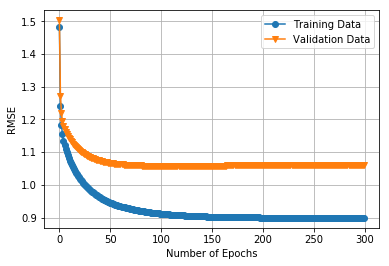

In [41]:
## Plot RMSE
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [42]:
## Funk Prediction
Funk_prediction=prediction(P,Q)

In [43]:
## Make predictions for top 10 movies when user_id=40
get_user_topn_movies(userid=48, pred=Funk_prediction,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Cutthroat Island (1995),3.652450,Nixon (1995),5.0
1,Waiting to Exhale (1995),3.466852,Ace Ventura: When Nature Calls (1995),4.0
2,Ace Ventura: When Nature Calls (1995),3.446301,Sabrina (1995),4.0
3,Heat (1995),3.367928,Cutthroat Island (1995),4.0
4,Nixon (1995),3.285714,Dracula: Dead and Loving It (1995),4.0
5,Jumanji (1995),3.279430,"American President, The (1995)",4.0
6,Dracula: Dead and Loving It (1995),3.247702,Father of the Bride Part II (1995),4.0
7,Father of the Bride Part II (1995),3.247535,Jumanji (1995),3.0
8,Four Rooms (1995),3.237117,Grumpier Old Men (1995),3.0
9,GoldenEye (1995),3.080207,Waiting to Exhale (1995),3.0


### Conclusion

From above, by using cosine similarity, classic SVD and funk SVD to make predictions, we can get the conclusions below:

1. In the recommendations baseds cosine similarity , we see the result of user similary is better than that of movie similarity, though the RMSE of these two method is very close

2. In the classic SVD, RMSE is lower than that of cosine similarity, however, the prediction result still seems not very ideal, only 5 movies from the real situation have been predicted as top 10 

3. In Funk SVD, RMSE is much lower( which is only around 1 for validation dataset) after 100 epochs, and we can see the result of prediction is very good. There are 7 movies have been hit on the top 10 movies, also, most of movies that got higher ratings in the actual situation have been given higher ratings in the prediction result.

Thus, Funk SVD is an efficent and accurate way to make recommendation system compared with cosine similarity method and classic SVD.
